In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

df = pd.read_csv('profiles.csv',encoding='utf-8')

In [2]:
print(list(df.columns))

['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7', 'essay8', 'essay9', 'ethnicity', 'height', 'income', 'job', 'last_online', 'location', 'offspring', 'orientation', 'pets', 'religion', 'sex', 'sign', 'smokes', 'speaks', 'status']


### Visualitzation of income values for the dataset

We can see that the the majority of rows (80%) doesn't have a valid value for this feature ('-1'). If we want to calculate the mean and median value we must extract this rows to make calculations. Also, cause valid rows is so low, we must not use this column for any regression or classification algorithm

In [9]:
print(df.income.value_counts(normalize=True))

-1          0.808094
 20000      0.049244
 100000     0.027041
 80000      0.018533
 30000      0.017482
 40000      0.016765
 50000      0.016265
 60000      0.012278
 70000      0.011794
 150000     0.010526
 1000000    0.008691
 250000     0.002486
 500000     0.000801
Name: income, dtype: float64


In rows with valid values of "income" column:
Mean = 104394.993
Median = 50000.0
Nº of rows = 11504


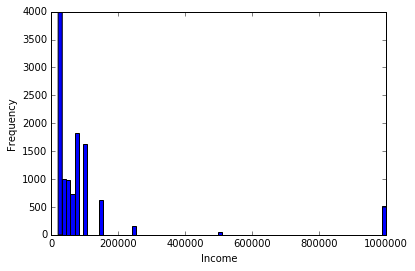

In [55]:
df_income=df['income'].loc[df['income']!= -1].copy()
print('In rows with valid values of "income" column:')
print('Mean = {:.3f}\nMedian = {}\nNº of rows = {}'.format(df_income.mean(),df_income.median(),df_income.shape[0]))

plt.hist(df_income, bins=80)
plt.xlabel("Income")
plt.ylabel("Frequency")
plt.show()

### Convert categorical values to numerical

Now, to make categorical columns usables to analisys, we must convert them to numerical values. We can use map function to achieve it in simple columns values: 


In [6]:
drink_mapping = {"not at all": 0, "rarely": 1, "socially": 2, "often": 3, "very often": 4, "desperately": 5}
drugs_mapping = {"never": 0, "sometimes": 1, "often": 2}
smokes_mapping = {"no": 0, "sometimes": 1, "when drinking": 2, "trying to quit": 3, "yes": 4}


df["drinks_code"] = df.drinks.map(drink_mapping)
df["drugs_code"] = df.drugs.map(drugs_mapping)
df["smokes_code"] = df.smokes.map(smokes_mapping)
df['sex_code']=df['sex'].map({'m':0, 'f':1})

print(df.drinks_code.value_counts())
print(df.drugs_code.value_counts())
print(df.smokes_code.value_counts())
print(df.sex_code.value_counts())

2.0    41780
1.0     5957
3.0     5164
0.0     3267
4.0      471
5.0      322
Name: drinks_code, dtype: int64
0.0    37724
1.0     7732
2.0      410
Name: drugs_code, dtype: int64
0.0    43896
1.0     3787
2.0     3040
4.0     2231
3.0     1480
Name: smokes_code, dtype: int64
0    35829
1    24117
Name: sex_code, dtype: int64


Or create some functions to classify more precisly other complex column values.
Note we need to preprocess a little bit more 'offspring' column to be able to apply some string based functions:

In [7]:
import html
df['offspring']=df['offspring'].apply(lambda x: html.unescape(str(x)))
df['offspring']=df['offspring'].apply(lambda x: str(x).replace("'", ""))

def has_pets(str):
    if 'has' in str:
        return 1
    else: 
        return 0

def has_kids(str):
    if 'has' in str:
        return 1
    else:
        return 0

def want_kids(str):
    if 'doesn’t' in str:
        return 0
    elif 'might want' or 'wants' in str:
        return 1
    
df['has_pets']=df['pets'].apply(lambda x: has_pets(str(x)))
df['has_kids']=df['offspring'].apply(lambda x: has_kids(str(x)))
df['want_kids']=df['offspring'].apply(lambda x: want_kids(x))

print(df.has_pets.value_counts())
print(df.has_kids.value_counts())
print(df.want_kids.value_counts())

0    45653
1    14293
Name: has_pets, dtype: int64
0    55027
1     4919
Name: has_kids, dtype: int64
1    40170
0    19776
Name: want_kids, dtype: int64


## Usign Classification algorithms

### Can we predict drugs consumption of population?

Now we want to predict the drugs consumtion of population from other features our dataset. 

Since drugs consumption are a categorical field ( never, sometimes, often), we use some supervised classification algorithm. We realised that this feature is higly unbalanced ( never: 37724, sometimes: 7732, often: 410), so we use SMOTE algorithm technique that create little variate records for all categories that doesn't have enough samples in dataset.  

#### Using Bayesian Algorithm

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from datetime import datetime

#selecting columns and dropping nans
df_selected_X = df[['want_kids', 'drinks_code', 'drugs_code','smokes_code','has_pets', 'has_kids', 'sex_code']].astype(np.float64)
df_selected_X.dropna(inplace=True, axis=0)

#popping dependent variable
df_selected_y = df_selected_X.pop('drugs_code').to_frame()

#Normalitzating values
scaler = MinMaxScaler()
scaler.fit_transform(df_selected_X)

#Splitting dataset in train and testing subsets
X_train, X_test, y_train, y_test = train_test_split(df_selected_X, 
                                                    df_selected_y, test_size=0.20, random_state=100)

#Appliying smote algorithm
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train.values.ravel())

#Training Bayesian classificator
start_time = datetime.now()
clf = MultinomialNB()
clf.fit(X_train,y_train)
print('MultinomialNB score: {:5.4f}'.format(clf.score(X_test, y_test)))

#Store predicted values
df_selected_y['Bayesian']=clf.predict(df_selected_X)

print(df_selected_y.drugs_code.value_counts(normalize=True))
print(df_selected_y.Bayesian.value_counts(normalize=True))

end_time = datetime.now()
print('Duration MultinomialNB classification: {}'.format(end_time - start_time))

MultinomialNB score: 0.7587
0.0    0.819626
1.0    0.171314
2.0    0.009060
Name: drugs_code, dtype: float64
0.0    0.819932
2.0    0.117779
1.0    0.062290
Name: Bayesian, dtype: float64
Duration MultinomialNB classification: 0:00:00.025982


In [49]:
from sklearn.metrics import f1_score, precision_score, recall_score
print('MultinomialNB f1_score : {:4.3f}'.format(f1_score(df_selected_y['drugs_code'], df_selected_y['Bayesian'], average='micro'))) 
print('MultinomialNB precision_score : {:4.3f}'.format(precision_score(df_selected_y['drugs_code'], df_selected_y['Bayesian'], average='micro')))  
print('MultinomialNB recall_score : {:4.3f}'.format(recall_score(df_selected_y['drugs_code'], df_selected_y['Bayesian'], average='micro'))) 


MultinomialNB f1_score : 0.756
MultinomialNB precision_score : 0.756
MultinomialNB recall_score : 0.756


#### Using Support Vector Machine Algorithm

In [54]:
#Training Support Vector Machine Classificator

start_time = datetime.now()

svm_clas= svm.SVC(kernel='rbf',gamma = 0.2,  C=5)
svm_clas.fit(X_train,y_train)

print('SVM score: {:5.4f}'.format(svm_clas.score(X_test, y_test)))

#Store predicted values
df_selected_y['SVM']=svm_clas.predict(df_selected_X)

print(df_selected_y.drugs_code.value_counts(normalize=True))
print(df_selected_y.SVM.value_counts(normalize=True))


end_time = datetime.now()
print('Duration SVM classification: {}'.format(end_time - start_time))

print('SVM f1_score : {:4.3f}'.format(f1_score(df_selected_y['drugs_code'], df_selected_y['SVM'], average='micro'))) 
print('SVM precision_score : {:4.3f}'.format(precision_score(df_selected_y['drugs_code'], df_selected_y['SVM'], average='micro')))  
print('SVM recall_score : {:4.3f}'.format(recall_score(df_selected_y['drugs_code'], df_selected_y['SVM'], average='micro'))) 


SVM score: 0.7561
0.0    0.819626
1.0    0.171314
2.0    0.009060
Name: drugs_code, dtype: float64
0.0    0.760819
1.0    0.165172
2.0    0.074009
Name: SVM, dtype: float64
Duration SVM classification: 0:06:52.336756
SVM f1_score : 0.755
SVM precision_score : 0.755
SVM recall_score : 0.755


### Classification algortithms comparation

With Bayesian or Suport Vector Machine Classificators, we obtain very similar scores, F1, accuracy and recall values. 
But the time used in the process is very larger in SVM classificator than in Bayesian Classificator ( almost 7 minutes vs 0.02 seconds, in my computer)



## Using regression algorithms

If we want to use some regression algorithms in this dataset, we must search some variable that not are categorical, that have a continous behaivour. No are so many in this dataset. 
We choose 'age' feature, and we will try to determine it using a linear model regressor algorithm, and a k-neigbours regressor technique

In [68]:
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor

#selecting columns and dropping nans
df_selected_X = df[['want_kids', 'drinks_code', 'drugs_code','smokes_code','has_pets', 'has_kids', 'sex_code', 'age']].astype(np.float64)
df_selected_X.dropna(inplace=True, axis=0)

#popping dependent variable
df_selected_y = df_selected_X.pop('age').to_frame()

#Normalitzating values
scaler = MinMaxScaler()
scaler.fit_transform(df_selected_X)

#Splitting dataset in train and testing subsets
X_train, X_test, y_train, y_test = train_test_split(df_selected_X, 
                                                    df_selected_y, test_size=0.20, random_state=100)

#Training Linear Model Regressor
start_time = datetime.now()
lm = linear_model.LinearRegression()
model = lm.fit(X_train,y_train)
print('linear Model score: {}'.format(lm.score(X_test, y_test)))

#Store predicted values
df_selected_y['LinRegre']=lm.predict(df_selected_X)
end_time = datetime.now()
print('Duration Linear Regression: {}'.format(end_time - start_time))

#Training KNeighbors Regressor
start_time = datetime.now()
regressor = KNeighborsRegressor(n_neighbors = 24, weights = "distance")
regressor.fit(X_train,y_train)
print('KNeighborsRegressor score: {}'.format(regressor.score(X_test, y_test)))

#Store predicted values
df_selected_y['KRegre']=regressor.predict(df_selected_X)
end_time = datetime.now()
print('Duration KNeighbors Regressor {}'.format(end_time - start_time))

linear Model score: 0.22954476564204174
Duration Linear Regression: 0:00:00.016492
KNeighborsRegressor score: 0.20774893604830247
Duration KNeighbors Regressor 0:00:07.579578


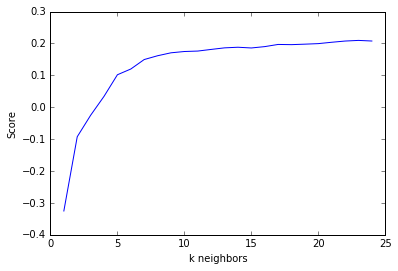

In [69]:
kscore=[]
for k in range(1,25):
    regressor = KNeighborsRegressor(n_neighbors = k, weights = "distance")
    regressor.fit(X_train,y_train)
    kscore.append([k,regressor.score(X_test, y_test)])

arr=np.array(kscore)
plt.plot(arr[:,0], arr[:,1])
plt.xlabel("k neighbors")
plt.ylabel("Score")
plt.show()


As we can see, that algorithms not are good enough to determine the age of people in this dataset. Only achieve 20% score. Linear Model algorithm is 7 times faster, but 7 seconds processing for k-neigbors alg  ( in my computer) is not a big problem to handle

## Conclusions

We are happy to use efficiently clasification algorithms to determine drugs use frequency for people of our dataset, but we realize that is tricky obtain really good results in data science. We can see trends of data, and certainly, we can analize very good all relations that not are real. It's so easy obtain poor results for classification and regression algorithms. Can be disapointing!

We supose that if we have 10 times more data than we workin this exercice, we can achieve better results.  